# GLV with saturation of interactions

#### Loading libraries

In [1]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
import scipy as sc
from scipy.optimize import fsolve
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colormaps

#### Plot settings

In [10]:
#tableau for plots
plt.style.use('tableau-colorblind10')

#colormap
cmap = plt.get_cmap('viridis')   #Blues

#set plot size
plt.rcParams["figure.autolayout"] = True

plt.rcParams['font.size'] = 10   # Default font size for text
plt.rcParams['axes.titlesize'] = 10   # Font size for axes titles
plt.rcParams['axes.labelsize'] = 11 # Font size for x and y labels
plt.rcParams['xtick.labelsize'] = 9 # Font size for x tick labels
plt.rcParams['ytick.labelsize'] = 9 # Font size for y tick labels


#set-up the font as in latex
plt.rcParams.update({
    "font.size": 10,
    "font.family": "serif",
    "font.serif": "cmr10",
    "mathtext.fontset": "cm",
    "axes.formatter.use_mathtext": True
})

#available styles
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


#### Paths placeholders

In [3]:
#placeholders for the data
folder_to_save_data = 'placeholder'
folder_to_save_results = 'placeholder'

#### Definition of utility functions

In [4]:
#saturating function
def J(x, K):
    return np.array(x/(1+K*x))

#NB: 1/K is the saturating value of the function

#derivative of the saturating function
def dJdx(x, K):
    return np.array(1/(1+K*x)**2)


#sample the interaction matrix
def inter_matrix(N, mu, sigma, gamma):
      
    alpha = np.zeros([N, N]) #matrix of interactions

    for i in range(N):
        for j in range(i+1, N):
            z = np.random.normal(size = 2)
            alpha[i, j] = mu/N+sigma/np.sqrt(N)*z[0]
            alpha[j, i] = mu/N+sigma/np.sqrt(N)*(gamma*z[0]+np.sqrt(1-gamma**2)*z[1])
    
    return alpha

#dynamics
def dynamics(x, t, S, mu, sigma, gamma, K, mig, alpha):
    return x*(1-x)+x*np.dot(alpha, J(x, K))+mig


#SELF CONSISTENT EQAUTIONS OF STATIONARY DMFT

#normal distributiion
def P_z(z):
    return 1/np.sqrt(2*np.pi)*np.exp(-z**2/2)

#derivative of the stationary solution
def f_prim(z, Q, q, chi, mu, sigma, gamma, K):
    eta = np.sqrt(q)*sigma*z
    t = 1+mu*Q+eta
    y = 1-gamma*sigma**2*chi
    return 2*t*(K-(4*K-2*K*(y-K*t))/(2*np.sqrt((y-K*t)**2+4*K*t)))/(K*t-y-np.sqrt((y-K*t)**2+4*K*t))**2-2/(K*t-y-np.sqrt((y-K*t)**2+4*K*t))

#stationary value of x given z
def x_z(z, Q, q, chi, mu, sigma, gamma, K):
    eta = np.sqrt(q)*sigma*z
    t = 1+mu*Q+eta
    y = 1-gamma*sigma**2*chi
    return -2*t/(K*t-y-np.sqrt((K*t-y)**2+4*K*t))

#integration boundary
def Delta(Q, q, mu, sigma):
    return (1+mu*Q)/(np.sqrt(q)*sigma)

#equation for Q
def integrand0(z, Q, q, chi, mu, sigma, gamma, K):
    return P_z(z)*J(x_z(z, Q, q, chi, mu, sigma, gamma, K), K)
    
#equation for q
def integrand1(z, Q, q, chi, mu, sigma, gamma, K):
    return P_z(z)*J(x_z(z, Q, q, chi, mu, sigma, gamma, K), K)**2

#equation for chi
def integrand2(z, Q, q, chi, mu, sigma, gamma, K):
    return P_z(z)*dJdx(x_z(z, Q, q, chi, mu, sigma, gamma, K), K)* f_prim(z, Q, q, chi, mu, sigma, gamma, K)

#equation for critical condition
def integrand3(z, Q, q, chi, mu, sigma, gamma, K):
    return P_z(z)*(dJdx(x_z(z, Q, q, chi, mu, sigma, gamma, K), K)/(1-gamma*sigma**2*chi*(dJdx(x_z(z, Q, q, chi, mu, sigma, gamma, K), K))))**2

#Self consistent equations
def equations_self_consistency(y, mu, sigma, gamma, K):
    
    Q = y[0]
    q = y[1]
    chi = y[2]

    eq0 = Q - sc.integrate.quad(integrand0, -Delta(Q, q, mu, sigma), np.inf, (Q, q, chi, mu, sigma, gamma, K))[0]
    eq1 = q - sc.integrate.quad(integrand1, -Delta(Q, q, mu, sigma), np.inf, (Q, q, chi, mu, sigma, gamma, K))[0]
    eq2 = chi - sc.integrate.quad(integrand2, -Delta(Q, q, mu, sigma), np.inf, (Q, q, chi, mu, sigma, gamma, K))[0]
    
    return [eq0, eq1, eq2]


#Critical-line set of self-consistent equations (search for critical sigma)
def equations_critical_condition(y, params):
    Q = y[0]
    q = y[1]
    chi = y[2]
    sigma = y[3]

    mu, gamma, K = params

    eq0 = Q - sc.integrate.quad(integrand0, -Delta(Q, q, mu, sigma), np.inf, (Q, q, chi, mu, sigma, gamma, K))[0]
    eq1 = q - sc.integrate.quad(integrand1, -Delta(Q, q, mu, sigma), np.inf, (Q, q, chi, mu, sigma, gamma, K))[0]
    eq2 = chi - sc.integrate.quad(integrand2, -Delta(Q, q, mu, sigma), np.inf, (Q, q, chi, mu, sigma, gamma, K))[0]
    eq3 = 1 -sigma**2*sc.integrate.quad(integrand3, -Delta(Q, q, mu, sigma), np.inf, (Q, q, chi, mu, sigma, gamma, K))[0]
    
    return [eq0, eq1, eq2, eq3]


#inverse of stationary solution
def f_inv_SAD(x, sigma, gamma, K, chi):
    return x-gamma*sigma**2*chi*J(x, K)

#derivative of the stationary solution
def f_prim_SAD(t, y, K):
    sq = np.sqrt(4*K*t+(K*t-y)**2)
    temp = 2*t*(K-(4*K-2*K*(-K*t+y))/(2*sq))/(K*t-y-sq)**2-2/(K*t-y-sq)
    return temp

#extinction probability
def prob_extinction(mu, sigma, gamma, avg_J, avg_J2):
    m = 1+mu*avg_J
    nu = sigma*np.sqrt(avg_J2)
    return  0.5*sc.special.erfc(m/(np.sqrt(2)*nu))

#Theoretical SAD
def SAD(x_list, mu, sigma, gamma, K, Q, q, chi, thresh = 0.001):
    
    m = 1 + mu*Q
    nu = sigma*np.sqrt(q)
    y = 1-gamma*sigma**2*chi
    
    p = []
    for i, x in enumerate(x_list):
        
        f_i = f_inv_SAD(x, sigma, gamma, K, chi)
        f_p = f_prim_SAD(f_i, y, K)
        out = 0
        
        
        if(i==0):
            #Extinction probability
            out = prob_extinction(mu, sigma,gamma, Q, q)
        
        else:
            #Gaussian (if gamma=0) contribute
            out = 1/(np.sqrt(2*np.pi)*nu)*np.exp(-(f_i-m)**2/(2*nu**2))/(f_p)
                       
        p.append(out)
        
    return np.array(p)


#function to compute the numerical order parameters h, d, MLE and dimension of activity
def numerical_characterization(parameters, hyperparameters):
    S, mu, sigma, gamma, K, mig, n = parameters
    N_steps, dt, stat, eps, N_trials = hyperparameters

    #time of simulation
    t = np.arange(0, N_steps)*dt

    #simulating the data
    alpha = inter_matrix(S, mu, sigma, gamma)

    sim1 = odeint(dynamics, np.random.uniform(0, 1, S), t, args = (S, mu, sigma, gamma, K, mig, alpha))
    sim2 = odeint(dynamics, np.random.uniform(0, 1, S), t, args = (S, mu, sigma, gamma, K, mig, alpha))

    stat1 = sim1[stat:, :]
    stat2 = sim2[stat:, :]
    
    #compute h
    temp1 = np.mean(stat1**2, axis = 1)
    temp2 = np.mean(stat1, axis = 1)**2
    h = np.mean(temp1-temp2)/np.mean(temp2) 
          
    #compute d
    temp3 = np.mean(np.mean((stat1-stat2)**2, axis = 0))
    temp4 = np.mean(np.mean( stat1 ,axis = 0)**2)
    d = temp3/temp4

    
    #compute MLE
    x1 = sim1[-1, :]
    x2 = x1 + eps*1/np.sqrt(S)

    t_mle = np.arange(0, 2)*dt

    d_temp = []
    for j in range(N_trials):
        run1 = odeint(dynamics, x1, t_mle, args = (S, mu, sigma, gamma, K, mig, alpha)) 
        run2 = odeint(dynamics, x2, t_mle, args = (S, mu, sigma, gamma, K, mig, alpha))

        d_temp.append(np.log(np.sqrt(np.sum((run1[-1, :]-run2[-1, :])**2))/eps)/dt)
            
        displacement = run2[-1, :]-run1[-1, :]

        x1 = run1[-1, :]
        x2 = run1[-1, :] + eps*displacement/np.sqrt(np.sum(displacement**2))

    mle = np.mean(d_temp)
    
    #compute dimension of activity
    cov_matrix = np.cov(sim1[stat:, :])
    dim = np.trace(cov_matrix)**2/np.trace(cov_matrix@cov_matrix)/S
        
    return [S, mu, sigma, gamma, K, mig, n, h, d, mle, dim]

## Panel 1 - Qualitative phase diagram

### Panel 1 - Data

In [5]:
sim_list = ['mu-3_sigma10_gamma-0.9_K0.1.npz', 'mu-3_sigma10_gamma0_K0.1.npz', 'mu-3_sigma10_gamma0.9_K0.1.npz', 'mu-3_sigma5_gamma-0.9_K0.1.npz', 'mu-3_sigma5_gamma0_K0.1.npz', 'mu-3_sigma5_gamma0.9_K0.1.npz'
            , 'mu-3_sigma2_gamma-0.9_K0.1.npz', 'mu-3_sigma2_gamma0_K0.1.npz', 'mu-3_sigma2_gamma0.9_K0.1.npz', 'mu-3_sigma1_gamma-0.9_K0.1.npz', 'mu-3_sigma1_gamma0_K0.1.npz', 'mu-3_sigma1_gamma0.9_K0.1.npz']

#### Panel 1 - Plot one column

#### Panle 1 - Plot two columns

### Panel 1 - yscale linear

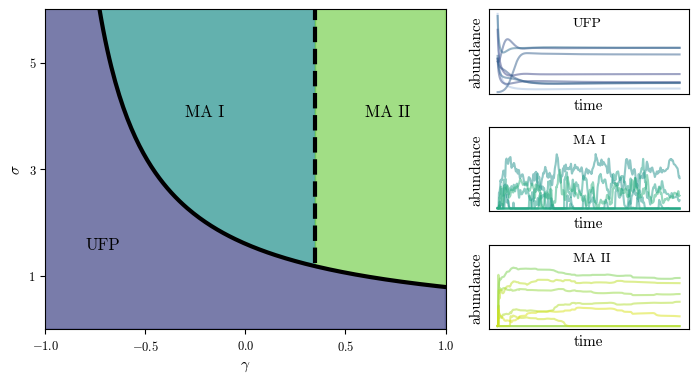

In [6]:
mu = -3
K = 0.1
K = 0.1

# Load Data
critical_line_df = pd.read_csv(folder_to_save_data + 'critical_line_mu{}_K{}.csv'.format(mu, K))
fixed_example = np.load(folder_to_save_data + 'mu-3_sigma1_gamma-0.9_K0.1.npz' )['x']
saltelli_example = np.load(folder_to_save_data + 'mu-3_sigma10_gamma0.9_K0.1.npz')['x']
volatile_example = np.load(folder_to_save_data + 'mu-3_sigma10_gamma0_K0.1.npz' )['x']

# Create figure with GridSpec layout
fig = plt.figure(figsize=(18/2.54, 10/2.54))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])  # Left: Phase Diagram, Right: Inserts

#choosing the color of each phase
colors = [0.2, 0.5, 0.8]
alpha = 0.7

#setting the seed
np.random.seed(1)

# ---- Left Panel: Phase Diagram ----
ax1 = plt.subplot(gs[0])
ax1.set_xlim([-1, 1])
ax1.set_xticks([-1, -0.5, 0, 0.5, 1])
#ax1.set_yscale('log')
ax1.set_ylim([0, 6])

# Set y-ticks only at chosen values
ax1.set_yticks([1, 3, 5])
ax1.set_yticklabels([1, 3, 5])

ax1.set_xlabel(r'$\gamma$')
ax1.set_ylabel(r'$\sigma$')
ax1.set_zorder(0)

# Plot critical lines
ax1.plot(critical_line_df['gamma'], critical_line_df['sigma'], color='black', lw=3)

# Add vertical boundary at gamma = 0.35
ax1.plot([0.35, 0.35], [1.24, 20], color='black', linestyle='--', lw = 3)

# Define a large enough sigma range to fill the whole plot
sigma_min, sigma_max = 0, 11  

critical_line_gamma = np.concatenate([np.array([-1]), critical_line_df['gamma'].values])
critical_line_sigma = np.concatenate([np.array([sigma_max]), critical_line_df['sigma'].values])

# Fill different phase regions
ax1.fill_between(critical_line_gamma, 0, critical_line_sigma, color= cmap(colors[0]), alpha  = alpha)
# Identify the minimum gamma value from the critical line
min_gamma = critical_line_df['gamma'].min()
# Define a large enough sigma range to fill the whole plot
sigma_min, sigma_max = 0, 11  

ax1.fill_between(critical_line_df['gamma'][critical_line_df['gamma'] <= 0.35], 
                 critical_line_df['sigma'][critical_line_df['gamma'] <= 0.35], 20, 
                 color=cmap(colors[1]),
                 alpha = alpha
                 )
ax1.fill_between(critical_line_df['gamma'][critical_line_df['gamma'] >= 0.35], 
                 critical_line_df['sigma'][critical_line_df['gamma'] >= 0.35], 20, 
                 color=cmap(colors[2]),
                 alpha = alpha,
                 )
                    

# Add text labels for phases
ax1.text(-0.8, 1.5, "UFP", fontsize=12, fontweight='bold', color='black')   # Lower region
ax1.text(-0.3, 4, "MA I", fontsize=12, fontweight='bold', color='black')   # Upper left region
ax1.text(0.6, 4, "MA II", fontsize=12, fontweight='bold', color='black')  # Upper right region

# ---- Right Panel: Three Stacked Subplots ----
gs_right = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[1], hspace=0.4)
examples = [fixed_example, volatile_example, saltelli_example]
titles = ["UFP", "MA I", "MA II"]
xs = [3300, 3300, 3300]
ys = [0.8, 112, 200]
ylims_max = [1, 140, 250]
ylims_min = [-0.005, -5, -10]


for i, (example_data, title, color) in enumerate(zip(examples, titles, colors)):
    ax = plt.subplot(gs_right[i])
    for j in range(8):  # Plot 8 example trajectories
        n = np.random.randint(0, example_data.shape[1])
        if i==0 and j==0:
            ax.plot(example_data[:, n], alpha=0.5, color='#a3bdde', label='Example trajectories')
        else:
            ax.plot(example_data[:, n], alpha=0.5, color=cmap(color + j * 0.02))
    
    ax.set_ylim([ylims_min[i], ylims_max[i]])
    ax.set_ylabel("abundance")
    ax.set_xlabel("time")
    ax.text(xs[i], ys[i], title)
    ax.set_xticks([]) # No X-ticks
    ax.set_yticks([]) # No Y-ticks

# Adjust layout and save
plt.tight_layout()
plt.savefig(folder_to_save_results + 'panel1.pdf')
plt.show()

## Panel 2 : Species Abundance Distribution (SAD)

### Panel 2 - Data

### Panel 2 - Plot

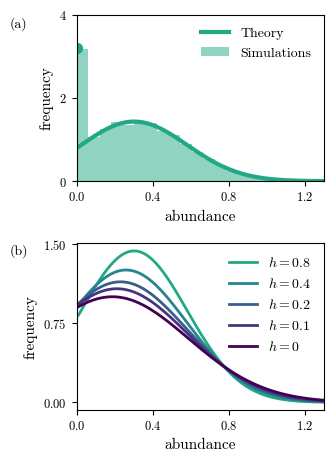

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(8.9/2.54, 12/2.54))

n_remove = 1 #number of points to not plot the extincted species part of the SAD

#loading the data

data_K0 = np.load(folder_to_save_data + 'SAD_mu-3_sigma1_gamma0_K0.npz')
x_list = data_K0['x_list']
theo_SAD_K0 = data_K0['SAD']

data_K01 = np.load(folder_to_save_data + 'SAD_mu-3_sigma1_gamma0_K0.1.npz')
x_list = data_K01['x_list']
theo_SAD_K01 = data_K01['SAD']
samples_K01 = data_K01['samples']

data_K02 = np.load(folder_to_save_data + 'SAD_mu-3_sigma1_gamma0_K0.2.npz')
x_list = data_K02['x_list']
theo_SAD_K02 = data_K02['SAD']

data_K04 = np.load(folder_to_save_data + 'SAD_mu-3_sigma1_gamma0_K0.4.npz')
x_list = data_K04['x_list']
theo_SAD_K04 = data_K04['SAD']

data_K08 = np.load(folder_to_save_data + 'SAD_mu-3_sigma1_gamma0_K0.8.npz')
x_list = data_K08['x_list']
theo_SAD_K08 = data_K08['SAD']
samples_K08 = data_K08['samples']


#plot a: comparison of data sample with theory

ax[0].plot(x_list[n_remove:], theo_SAD_K08[n_remove:], label = 'Theory', lw = 3, color = cmap(0.6))

n, bins, patches  = ax[0].hist(samples_K08, bins=25, density = True, alpha = 0.5, color = cmap(0.6), label = 'Simulations')
DeltaX = np.diff(bins)
ax[0].scatter(x_list[0], theo_SAD_K08[0]/np.diff(bins)[0]+np.sum(theo_SAD_K08[x_list<bins[1]][1:]*np.diff(x_list)[1])/(np.diff(bins)[0]),  color = cmap(0.6), s = 50)# label = 'Extinction')
ax[0].set_xlabel(r'abundance')
ax[0].set_ylabel(r'frequency')
ax[0].set_xlim([0, 1.3])
ax[0].set_ylim([0, 1])

ax[0].set_xticks([0, 0.4, 0.8, 1.2])
ax[0].set_yticks([0,2, 4])

ax[0].text(-0.35, 3.7,'(a)')
ax[0].legend(loc = 'upper right', frameon = False)

ax[1].plot(x_list[n_remove:], theo_SAD_K08[n_remove:], label = r'$h=0.8$', lw = 2, color = cmap(0.6))
ax[1].plot(x_list[n_remove:], theo_SAD_K04[n_remove:], label = r'$h=0.4$', lw = 2, color = cmap(0.45))
ax[1].plot(x_list[n_remove:], theo_SAD_K02[n_remove:], label = r'$h=0.2$', lw = 2, color = cmap(0.3))
ax[1].plot(x_list[n_remove:], theo_SAD_K01[n_remove:], label = r'$h=0.1$', lw = 2, color = cmap(0.15))
ax[1].plot(x_list[n_remove:], theo_SAD_K0[n_remove:], label = r'$h=0$', lw = 2, color = cmap(0))


ax[1].set_xlabel(r'abundance')
ax[1].set_ylabel(r'frequency')
ax[1].set_xlim([0, 1.3])
ax[1].legend(frameon=False, loc = 'upper right')
ax[1].set_xticks([0, 0.4, 0.8, 1.2])
ax[1].set_yticks([0, 0.75, 1.5])

ax[1].text(-0.35, 1.4,'(b)')

fig.tight_layout()
plt.savefig(folder_to_save_results + 'panel2.pdf')

## Panel 3 - Phase diagram

#### Panel 3 - Data

#### Panel 3 - Plot

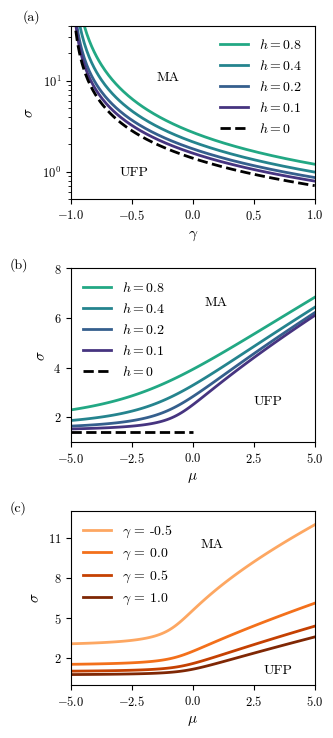

In [9]:
fig, ax = plt.subplots(3, 1, figsize=(8.9/2.54, 19/2.54))

#gamma-sigma
df = pd.read_csv(folder_to_save_data + 'test_critical_line_gamma-sigma.csv')

for i, K in enumerate(np.unique(df['K'])[::-1]):
    ax[0].plot(df['gamma'][df['K']==K], df['sigma'][df['K']==K], lw = 2, label = r'$h = {}$'.format(K), color = cmap(0.6-i*0.15))


gamma_list = df['gamma'].unique()

ax[0].plot(gamma_list, np.sqrt(2/(1+gamma_list)**2), lw = 2, label = r'$h = 0$', color = 'black', linestyle = '--')

ax[0].set_xlabel(r'$\gamma$')
ax[0].set_ylabel(r'$\sigma$')
ax[0].legend(frameon = False)

ax[0].set_xlim([-1, 1])
ax[0].set_ylim([0.5, 40])
ax[0].set_yscale('log')
ax[0].set_xticks([-1, -0.5, 0, 0.5, 1])
ax[0].text(-1.4, 46, '(a)')
#ax[0].text(0.7, 7.5, r'$\mu$ = {}'.format(mu))


#mu-sigma changing gamma
df = pd.read_csv(folder_to_save_data + 'critical_line_mu-sigma_changing_gamma.csv')

cmap2 = plt.get_cmap('Oranges')

for i,gamma in enumerate(np.unique(df['gamma'])[1:]):
    ax[2].plot(df['mu'][df['gamma']==gamma], df['sigma'][df['gamma']==gamma], lw = 2, label = r'$\gamma$ = {}'.format(gamma), color = cmap2(0.4+i*0.2))

ax[2].set_xlabel(r'$\mu$')
ax[2].set_ylabel(r'$\sigma$')


ax[2].legend(frameon = False)
ax[2].set_xlim([-5, 5])
ax[2].set_xticks([-5, -2.5, 0, 2.5, 5])
ax[2].set_yticks([2, 5, 8, 11])
ax[2].set_ylim([0, 13])
ax[2].text(-7.5, 13, '(c)')

#mu-sigma changing K
df = pd.read_csv(folder_to_save_data + 'critical_line_mu-sigma_changing_K.csv')

ax[1].set_xlabel(r'$\mu$')
ax[1].set_ylabel(r'$\sigma$')

#Plot
for i,K in enumerate(np.unique(df['K'])[::-1]):
    ax[1].plot(df['mu'][df['K']==K], df['sigma'][df['K']==K], lw = 2, label = r'$h = {}$'.format(K),  color = cmap(0.6-i*0.15))


ax[1].plot(np.linspace(-5, 0, 100), np.sqrt(2)*np.ones(100), lw = 2, label = r'$h = 0$', color = 'black', linestyle = '--')
ax[1].legend(frameon = False)
ax[1].set_xlim([-5, 5])
ax[1].set_xticks([-5, -2.5, 0, 2.5, 5])
ax[1].set_ylim([1, 8])
ax[1].set_yticks([2, 4, 6, 8])
ax[1].text(-7.5, 8, '(b)')


# Add 'MA' above and 'UFP' below a representative line
ax[0].text(-0.3, 10, 'MA')#, verticalalignment='bottom', horizontalalignment='center')
ax[0].text(-0.6, 0.9, 'UFP')#, verticalalignment='top', horizontalalignment='center')

ax[1].text(0.5, 6.5, 'MA')# fontsize=10 verticalalignment='bottom', horizontalalignment='center')
ax[1].text(2.5, 2.5, 'UFP')#, fontsize=10, verticalalignment='top', horizontalalignment='center')


ax[2].text(0.8, 10.0, 'MA', fontsize=10, verticalalignment='bottom', horizontalalignment='center')
ax[2].text(3.5, 1.5, 'UFP', fontsize=10, verticalalignment='top', horizontalalignment='center')

fig.tight_layout()
plt.savefig(folder_to_save_results + 'panel3.pdf')

## Panel 4 - Numerical characterization of the dynamical phases

#### Panel 4 - Data

#### Panel 4 - Plot

#### Two column-version

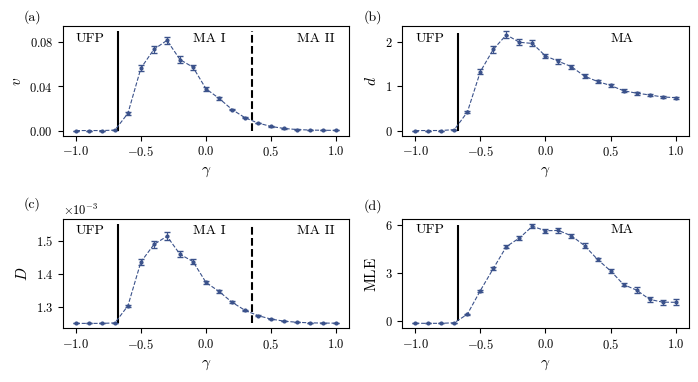

In [18]:
mu = -3
sigma = 5
K = 0.1

#choosing the color
color = cmap(0.25)


#loading the data
df = pd.read_csv(folder_to_save_data + 'numerical_characterization_mu{}_sigma{}_K{}.csv'.format(mu, sigma, K))
df2 = df.groupby('gamma').mean()
df3 = df.groupby('gamma').std()


fig, ax = plt.subplots(2, 2,  figsize = (18/2.54, 10/2.54))

ax[0, 0].errorbar(df2.index, df2['h'], df3['h']/15, linestyle= '--', lw = 0.8, marker = '.', markersize = 4, capsize = 2, label = 'h', color = color)
ax[0, 0].set_xlabel(r'$\gamma$')
ax[0, 0].set_ylabel(r'$v$')
ax[0, 0].set_yticks([0, 0.04, 0.08])
ax[0, 0].vlines(x = -0.675, ymin = 0, ymax = 0.09, color = 'black', linestyle = '-')
ax[0, 0].vlines(x = 0.35, ymin = 0, ymax = 0.09, color = 'black', linestyle = '--')
ax[0, 0].text(-1.4, 0.1, '(a)')

ax[0, 1].errorbar(df2.index, df2['d'], df3['d']/15,  linestyle= '--', lw = 0.8, marker = '.', markersize = 4, capsize = 2,  label = 'd', color = color)
ax[0, 1].set_xlabel(r'$\gamma$')
ax[0, 1].set_ylabel(r'$d$')
ax[0, 1].set_yticks([0, 1, 2])
ax[0, 1].vlines(x = -0.675, ymin = 0, ymax = 2.2, color = 'black', linestyle = '-')
ax[0, 1].text(-1.4, 2.48, '(b)')


ax[1, 0].errorbar(df2.index, df2['dim'], df3['dim']/15,  linestyle= '--', lw = 0.8, marker = '.', markersize = 4, capsize = 2,  color= color)
ax[1, 0].set_xlabel(r'$\gamma$')
ax[1, 0].set_ylabel(r'$D$')
ax[1, 0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[1, 0].vlines(x = -0.675, ymin = 0.00125, ymax = 0.00155, color = 'black', linestyle = '-')
ax[1, 0].vlines(x = 0.35, ymin = 0.00125, ymax = 0.00155, color = 'black', linestyle = '--')
ax[1, 0].text(-1.4, 0.0016, '(c)')

ax[1, 1].errorbar(df2.index, df2['mle'], df3['mle']/15,  linestyle= '--', lw = 0.8, marker = '.', markersize = 4, capsize = 2,  label = 'MLE', color = color)
ax[1, 1].set_xlabel(r'$\gamma$')
ax[1, 1].set_ylabel(r'$\text{MLE}$')
ax[1, 1].set_yticks([0, 3, 6])
ax[1, 1].vlines(x = -0.675, ymin = 0, ymax = 6, color = 'black', linestyle = '-')
ax[1, 1].text(-1.4, 7, '(d)')

ax[0,0].text(-1, 0.08, 'UFP')
ax[0,0].text(-0.1, 0.08, 'MA I')
ax[0,0].text(0.7, 0.08, 'MA II')


ax[0,1].text(-1, 2, 'UFP')
ax[0,1].text(0.5, 2, 'MA')

ax[1,0].text(-1, 0.00152, 'UFP')
ax[1,0].text(-0.1, 0.00152, 'MA I')
ax[1,0].text(0.7, 0.00152, 'MA II')


ax[1,1].text(-1, 5.5, 'UFP')
ax[1,1].text(0.5, 5.5, 'MA')

fig.tight_layout()
#plt.savefig(folder_to_save_results + 'panel4.pdf')

#### y-logscale

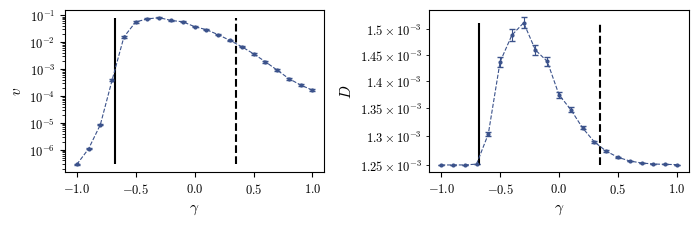

In [32]:
mu = -3
sigma = 5
K = 0.1

# choosing the color
color = cmap(0.25)

# loading the data
df = pd.read_csv(folder_to_save_data + 'numerical_characterization_mu{}_sigma{}_K{}.csv'.format(mu, sigma, K))
df2 = df.groupby('gamma').mean()
df3 = df.groupby('gamma').std()

# Create figure with 1 row and 2 columns
fig, ax = plt.subplots(1, 2, figsize=(18/2.54, 6/2.54))

# --- (a) h vs gamma ---
ax[0].errorbar(df2.index, df2['h'], df3['h']/15,
               linestyle='--', lw=0.8, marker='.', markersize=4, capsize=2,
               label='h', color=color)
ax[0].set_xlabel(r'$\gamma$')
ax[0].set_ylabel(r'$v$')
ax[0].set_yscale('log')
ax[0].vlines(x=-0.675, ymin=df2['h'].min(), ymax=df2['h'].max(), color='black', linestyle='-')
ax[0].vlines(x=0.35, ymin=df2['h'].min(), ymax=df2['h'].max(), color='black', linestyle='--')

# --- (c) dim vs gamma ---
ax[1].errorbar(df2.index, df2['dim'], df3['dim']/15,
               linestyle='--', lw=0.8, marker='.', markersize=4, capsize=2,
               color=color)
ax[1].set_xlabel(r'$\gamma$')
ax[1].set_ylabel(r'$D$')
ax[1].set_yscale('log')
ax[1].vlines(x=-0.675, ymin=df2['dim'].min(), ymax=df2['dim'].max(), color='black', linestyle='-')
ax[1].vlines(x=0.35, ymin=df2['dim'].min(), ymax=df2['dim'].max(), color='black', linestyle='--')


fig.tight_layout()
plt.savefig(folder_to_save_results + 'panel4_logscale.pdf')
plt.show()


### Supplementary Panel -SAD

In [58]:
mu_list = [-2, 2]
sigma_list = [0.5, 1]
gamma_list = [-0.5, 0.5]
K_list = [0.4, 0.8]

mig = 1e-8


initial_guess = [0.5, 0.5, 0.5]

#SIMULATIONS FOR COMPARISON
N_sim = 10
S = 1000
dt = 0.01
t = np.arange(0, 10_000)*dt

for mu in mu_list:
    for sigma in sigma_list:
        for gamma in gamma_list:
            for K in K_list:

                print('Computing SAD for mu = {}, sigma = {}, gamma = {}, K = {}'.format(mu, sigma, gamma, K))
                #Self-consistency solutions
               

                # Solve the system numerically
                solution = fsolve(equations_self_consistency, initial_guess, args = (mu, sigma, gamma, K))

                Q = solution[0]
                q = solution[1]
                chi = solution[2]

                #SAD
                x_list = np.linspace(0, 10, 1000)
                theo_SAD = SAD(x_list, mu, sigma, gamma, K, Q, q, chi )


                samples = np.zeros([N_sim*S])
                for i in range(N_sim):
                    alpha = inter_matrix(S, mu, sigma, gamma)
                    x = np.random.uniform(0, 1, S)
                    x = odeint(dynamics, x, t, args = (S, mu, sigma, gamma, K, 0, alpha))
                    samples[i*S:(i+1)*S] = np.mean(x[-500:, :], axis = 0)


                #saving the data
                np.savez(folder_to_save_data + 'SAD_mu{}_sigma{}_gamma{}_K{}.npz'.format(mu, sigma, gamma, K), x_list = x_list, SAD = theo_SAD, samples = samples)

Computing SAD for mu = -2, sigma = 0.5, gamma = -0.5, K = 0.4
Computing SAD for mu = -2, sigma = 0.5, gamma = -0.5, K = 0.8
Computing SAD for mu = -2, sigma = 0.5, gamma = 0.5, K = 0.4
Computing SAD for mu = -2, sigma = 0.5, gamma = 0.5, K = 0.8
Computing SAD for mu = -2, sigma = 1, gamma = -0.5, K = 0.4
Computing SAD for mu = -2, sigma = 1, gamma = -0.5, K = 0.8
Computing SAD for mu = -2, sigma = 1, gamma = 0.5, K = 0.4
Computing SAD for mu = -2, sigma = 1, gamma = 0.5, K = 0.8
Computing SAD for mu = 2, sigma = 0.5, gamma = -0.5, K = 0.4
Computing SAD for mu = 2, sigma = 0.5, gamma = -0.5, K = 0.8
Computing SAD for mu = 2, sigma = 0.5, gamma = 0.5, K = 0.4
Computing SAD for mu = 2, sigma = 0.5, gamma = 0.5, K = 0.8
Computing SAD for mu = 2, sigma = 1, gamma = -0.5, K = 0.4
Computing SAD for mu = 2, sigma = 1, gamma = -0.5, K = 0.8
Computing SAD for mu = 2, sigma = 1, gamma = 0.5, K = 0.4
Computing SAD for mu = 2, sigma = 1, gamma = 0.5, K = 0.8


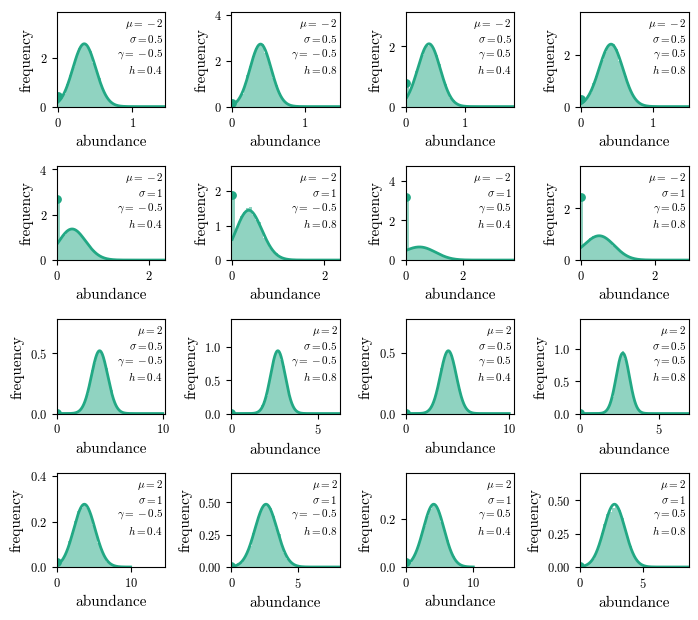

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# fixed grid
n_rows, n_cols = 4, 4
n_panels = n_rows * n_cols

fig, ax = plt.subplots(n_rows, n_cols,
                       figsize=(18/2.54, n_rows*4/2.54),
                       squeeze=False)

ax = ax.flatten()

plot_idx = 0
for mu in mu_list:
    for sigma in sigma_list:
        for gamma in gamma_list:
            for K in K_list:

                if plot_idx >= n_panels:
                    break  # only fill up to 16 panels

                # load data
                data = np.load(folder_to_save_data + f'SAD_mu{mu}_sigma{sigma}_gamma{gamma}_K{K}.npz')
                x_list = data['x_list']
                theo_SAD = data['SAD']
                samples = data['samples']

                # histogram
                n, bins, patches = ax[plot_idx].hist(
                    samples, bins=25, density=True, alpha=0.5,
                    color=cmap(0.6))

                # theory curve
                ax[plot_idx].plot(
                    x_list[n_remove:], theo_SAD[n_remove:],
                    lw=2, color=cmap(0.6)
                )

                # extinction point
                DeltaX = np.diff(bins)
                ax[plot_idx].scatter(
                    x_list[0],
                    theo_SAD[0]/DeltaX[0] +
                    np.sum(theo_SAD[x_list < bins[1]][1:] * np.diff(x_list)[1]) / DeltaX[0],
                    color=cmap(0.6), s=28
                )

                # automatic xlim (based on samples)
                if len(samples) > 0:
                    xmax = samples.max()
                else:
                    xmax = x_list.max()
                ax[plot_idx].set_xlim([-0.01, xmax * 1.5])  # add margin

                # automatic ylim (based on both histogram + theory) + extra headroom
                y_max = max(n.max() if len(n) > 0 else 0,
                            theo_SAD.max())
                ax[plot_idx].set_ylim([0, y_max * 1.5])  # extra space for text

                # axis labels
                ax[plot_idx].set_xlabel(r'abundance')
                ax[plot_idx].set_ylabel(r'frequency')

                # parameter values as text in corner (background only, no frame)
                ax[plot_idx].text(
                    0.98, 0.95,
                    fr'$\mu={mu}$' + "\n"
                    fr'$\sigma={sigma}$' + "\n"
                    fr'$\gamma={gamma}$' + "\n"
                    fr'$h={K}$',
                    transform=ax[plot_idx].transAxes,
                    ha='right', va='top',
                    fontsize=8,
                    )#bbox=dict(facecolor='white', alpha=0.8, pad=2)  # no edgecolor
                

                plot_idx += 1

# hide unused axes
for k in range(plot_idx, n_panels):
    ax[k].axis('off')

plt.tight_layout()

plt.savefig(folder_to_save_results + 'supplementary_panel_SAD.pdf')

### Supplementary Figure Panel - Numerical validation

In [5]:
def numerical_characterization_costum(parameters, hyperparameters):
    S, mu, sigma, gamma, K, mig, n = parameters
    N_steps, dt, stat, eps, N_trials = hyperparameters

    #time of simulation
    t = np.arange(0, N_steps)*dt

    #simulating the data
    alpha = inter_matrix(S, mu, sigma, gamma)

    sim1 = odeint(dynamics, np.random.uniform(0, 1, S), t, args = (S, mu, sigma, gamma, K, mig, alpha))
    sim2 = odeint(dynamics, np.random.uniform(0, 1, S), t, args = (S, mu, sigma, gamma, K, mig, alpha))

    stat1 = sim1[stat:, :]
    stat2 = sim2[stat:, :]
    
    #compute h
    temp1 = np.mean(stat1**2, axis = 1)
    temp2 = np.mean(stat1, axis = 1)**2
    h = np.mean(temp1-temp2)/np.mean(temp2) 
          
    #compute d
    temp3 = np.mean(np.mean((stat1-stat2)**2, axis = 0))
    temp4 = np.mean(np.mean( stat1 ,axis = 0)**2)
    d = temp3/temp4
    
    #compute MLE
    mle = 0
    
    #compute dimension of activity
    cov_matrix = np.cov(sim1[stat:, :])
    dim = np.trace(cov_matrix)**2/np.trace(cov_matrix@cov_matrix)/S
        
    return [S, mu, sigma, gamma, K, mig, n, h, d, mle, dim]

In [6]:
#### gamma-sigma phase diagram, mu, K fixed
K_list = [0.1]
mu_list = [-3]
gamma_list = [-0.5, -0.25, 0, 0.25, 0.5, 0.75]

S = 1000
mig = 1e-8

dt = 0.01
timesteps = 5_000
stat = 4_500
N_sam = 225
eps = 1e-8
N_trials = 100
hyperparameters = [timesteps, dt, stat, eps, N_trials]

In [16]:
dfc  = pd.DataFrame(columns = ['mu', 'sigma', 'gamma', 'K', 'Q', 'q', 'chi'])
df = pd.DataFrame(columns = ['S', 'mu', 'sigma', 'gamma', 'K', 'mig', 'n', 'h', 'd', 'mle', 'dim'])

i = 0
for K in K_list:
    for gamma in gamma_list:
        for mu in mu_list:
            params = [mu, gamma, K]
            print(params)
            # Solve the system numerically
            solution = fsolve(equations_critical_condition, [0.3, 0.3, 0.1, 1], params)
            dfc.loc[len(dfc)] = [mu, solution[3], gamma, K, solution[0], solution[1], solution[2]]
            i = i +1
            #critical c
            sigmac = solution[3]

            print('solution = ', 'mu = {}, gamma = {}, K = {}, sigma_c = {}'.format(mu, gamma, K, solution[3]))
            
            print('Computing numerical characterization for mu = {}, gamma = {}, K = {}, sigma_c = {}'.format(mu, gamma, K, solution[3]))
            sigma_list = np.linspace(sigmac-1, sigmac+1, 21)
            data = Parallel(n_jobs = -1, verbose = 1)(delayed(numerical_characterization_costum)([S, mu, sigma, gamma, K, mig, n], hyperparameters) for sigma in sigma_list for n in range(N_sam))
            df = pd.concat([df, pd.DataFrame(data, columns = ['S', 'mu', 'sigma', 'gamma', 'K', 'mig', 'n', 'h', 'd', 'mle', 'dim'])], ignore_index=True)
            
df.to_csv(folder_to_save_data + 'numerical_characterization_gamma-sigma-Supp-panel2.csv', index = False)
dfc.to_csv(folder_to_save_data + 'critical_line_gamma-sigma-Supp-panel2.csv', index = False)

[-3, -0.5, 0.1]
solution =  mu = -3, gamma = -0.5, K = 0.1, sigma_c = 3.236084920753422
Computing numerical characterization for mu = -3, gamma = -0.5, K = 0.1, sigma_c = 3.236084920753422


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 350 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 700 tasks      | elapsed:  2.0min


In [7]:
df = pd.read_csv(folder_to_save_data + 'numerical_characterization_gamma-sigma-Supp-panel2.csv')
dfc = pd.read_csv(folder_to_save_data + 'critical_line_gamma-sigma-Supp-panel2.csv')

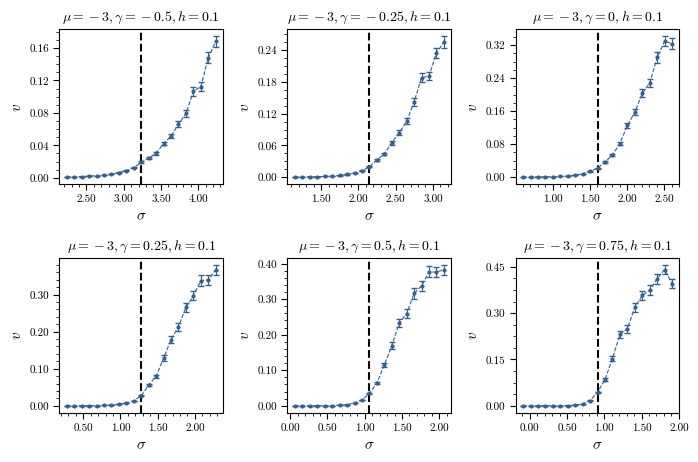

In [18]:
import math
import matplotlib.ticker as mticker

# number of subplots
nplots = len(mu_list) * len(gamma_list) * len(K_list)
ncols = 3
nrows = math.ceil(nplots / ncols)

fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols,
    figsize=(18/2.54 * ncols/3, 6/2.54 * nrows),
    squeeze=False
)

axes = axes.flatten()

i = 0
for mu in mu_list:
    for gamma in gamma_list:
        for K in K_list:
            ax = axes[i]

            df_temp = df[(df['mu']==mu) & (df['gamma']==gamma) & (df['K']==K)]
            df_mean = df_temp.groupby(['sigma']).mean().reset_index()
            df_std =  df_temp.groupby(['sigma']).std().reset_index()

            # Plot error bars for v
            ax.errorbar(
                df_mean['sigma'], df_mean['d'], df_std['d']/15,
                linestyle='--', lw=0.8, marker='.', markersize=4,
                capsize=2, color=cmap(0.3)
            )

            # Vertical reference line
            sigma_val = dfc.loc[
                (dfc['mu']==mu) & (dfc['gamma']==gamma) & (dfc['K']==K),
                'sigma'
            ].iloc[0]
            ax.axvline(x=sigma_val, ymin=0, ymax=1, color='black', linestyle='--')

            # Labels and title
            ax.set_xlabel(r'$\sigma$')
            ax.set_ylabel(r'$v$')  # ← changed from D to v
            ax.set_title(fr'$\mu={mu}, \gamma={gamma}, h={K}$')

            # Improved ticks only
            ax.xaxis.set_major_locator(mticker.MaxNLocator(5))
            ax.yaxis.set_major_locator(mticker.MaxNLocator(5))
            ax.minorticks_on()
            ax.tick_params(axis='both', which='major', labelsize=8, length=4, width=0.8)
            ax.tick_params(axis='both', which='minor', length=2, width=0.6)
            ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
            ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

            i += 1

# remove empty axes if grid has extra
for j in range(i, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig(folder_to_save_results + 'supplementary_panel2.pdf')


### Supplementary panel - effects of the migration term lambda on the Multiple attractors phase

In [6]:
S = 800
mu = -3
sigma = 5
K = 0.1
mig = 1e-8
gamma_list = np.linspace(-1, 1, 21)
mig_list = [1e-5, 1e-8, 1e-11]

dt = 0.01

timesteps = 5_000
stat = 4_500

N_sam = 225

eps = 1e-8
N_trials = 100

parameters = []
for n in range(N_sam):
    for gamma in gamma_list:
        for mig in mig_list:
            parameters.append([S, mu, sigma, gamma, K, mig, n])


hyperparameters = [timesteps, dt, stat, eps, N_trials]


print('Number of parameters:', len(parameters))
data = Parallel(n_jobs = -1, verbose = 11)(delayed(numerical_characterization)(par, hyperparameters) for par in parameters)

df = pd.DataFrame(data, columns = ['S', 'mu', 'sigma', 'gamma', 'K', 'mig', 'n', 'h', 'd', 'mle', 'dim'])
df.to_csv(folder_to_save_data + 'mig2_numerical_characterization_mu{}_sigma{}_K{}.csv'.format(mu, sigma, K))

"\nprint('Number of parameters:', len(parameters))\ndata = Parallel(n_jobs = -1, verbose = 11)(delayed(numerical_characterization)(par, hyperparameters) for par in parameters)\n\ndf = pd.DataFrame(data, columns = ['S', 'mu', 'sigma', 'gamma', 'K', 'mig', 'n', 'h', 'd', 'mle', 'dim'])\ndf.to_csv(folder_to_save_data + 'mig2_numerical_characterization_mu{}_sigma{}_K{}.csv'.format(mu, sigma, K))\n"

/tmp/ipykernel_42393/3746879224.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


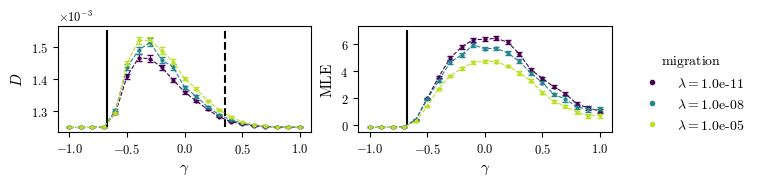

In [69]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.cm as cm
from matplotlib.lines import Line2D


# === Parameters ===
mu = -3
sigma = 5
K = 0.1

#data loading
df = pd.read_csv(folder_to_save_data + f'mig_numerical_characterization_mu{mu}_sigma{sigma}_K{K}.csv')

# === Choose color map ===
cmap = cm.get_cmap('viridis')

# === Group by mig and gamma ===
df2 = df.groupby(['mig', 'gamma']).mean().reset_index()
df3 = df.groupby(['mig', 'gamma']).std().reset_index()

# === Get unique mig values and assign colors ===
mig_values = sorted(df['mig'].unique())
colors = cmap(np.linspace(0, 0.9, len(mig_values)))

# === Helper function: scientific notation for legend ===
def sci_notation(x):
    return f"{x:.1e}"

# === Create bottom two subplots (1 row, 2 columns) ===
fig, ax = plt.subplots(1, 2, figsize=(18/2.54, 5/2.54))

# === PANEL (c): D ===
for color, mig in zip(colors, mig_values):
    sub_mean = df2[df2['mig'] == mig]
    sub_std = df3[df3['mig'] == mig]
    ax[0].errorbar(sub_mean['gamma'], sub_mean['dim'], sub_std['dim']/15,
                   linestyle='--', lw=0.8, marker='.', markersize=4,
                   capsize=2, color=color)
ax[0].set_xlabel(r'$\gamma$')
ax[0].set_ylabel(r'$D$')
ax[0].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

# Add vertical reference lines
ax[0].vlines(x=-0.675, ymin=0.00125, ymax=0.00155, color='black', linestyle='-')
ax[0].vlines(x=0.35, ymin=0.00125, ymax=0.00155, color='black', linestyle='--')

# === PANEL (d): MLE ===
for color, mig in zip(colors, mig_values):
    sub_mean = df2[df2['mig'] == mig]
    sub_std = df3[df3['mig'] == mig]
    ax[1].errorbar(sub_mean['gamma'], sub_mean['mle'], sub_std['mle']/15,
                   linestyle='--', lw=0.8, marker='.', markersize=4,
                   capsize=2, color=color)
ax[1].set_xlabel(r'$\gamma$')
ax[1].set_ylabel(r'$\text{MLE}$')

# Add vertical reference line
ax[1].vlines(x=-0.675, ymin=0, ymax=7, color='black', linestyle='-')

# === Layout ===
fig.tight_layout()
plt.subplots_adjust(right=0.87)

# === Custom legend: same marker, different colors ===
legend_handles = [
    Line2D([0], [0], color=color, marker='.', linestyle='None', markersize=6)
    for color in colors
]
legend_labels = [r'$\lambda=$' + sci_notation(mig) for mig in mig_values]

leg = fig.legend(
    handles=legend_handles,
    labels=legend_labels,
    title=r'$\text{migration}$',
    loc='center left',
    bbox_to_anchor=(0.89, 0.5),
    frameon=False
)

plt.setp(leg.get_frame(), alpha=0)

# === Show or save ===
plt.savefig(folder_to_save_results + 'supp_panel_migration_effects.pdf', bbox_inches='tight')
plt.show()


### Supplementrary panel -studying the scaling with number of species

In [5]:
#function to compute the numerical order parameters h, d, MLE and dimension of activity
def numerical_characterization_dimension_of_activity(parameters, hyperparameters):
    S, mu, sigma, gamma, K, mig, n = parameters
    N_steps, dt, stat, eps, N_trials = hyperparameters

    #time of simulation
    t = np.arange(0, N_steps)*dt

    #simulating the data
    alpha = inter_matrix(S, mu, sigma, gamma)

    sim1 = odeint(dynamics, np.random.uniform(0, 1, S), t, args = (S, mu, sigma, gamma, K, mig, alpha))

    stat1 = sim1[stat:, :]
    
    h = 0
    d = 0
    mle = 0
    
    #compute dimension of activity
    cov_matrix = np.cov(sim1[stat:, :])
    dim = np.trace(cov_matrix)**2/np.trace(cov_matrix@cov_matrix)/S
        
    return [S, mu, sigma, gamma, K, mig, n, h, d, mle, dim]

In [6]:
S_list = [1400] #[800, 1000, 1200, 1400]
mu = -3
sigma = 5
K = 0.1
mig = 1e-8
gamma_list = np.linspace(-1, 1, 21)

dt = 0.05

timesteps = 2_500
stat = 2_225

N_sam = 64 #225

eps = 1e-8
N_trials = 0

parameters = []
for n in range(N_sam):
    for gamma in gamma_list:
        for S in S_list:
            parameters.append([S, mu, sigma, gamma, K, mig, n])


hyperparameters = [timesteps, dt, stat, eps, N_trials]

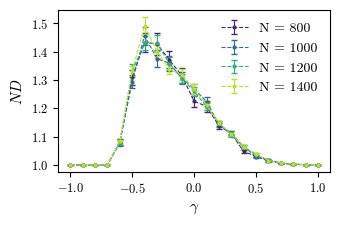

In [25]:
import matplotlib.pyplot as plt
import numpy as np

S_list = [800, 1000, 1200, 1400]
colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(S_list)))  # evenly spaced colors

plt.figure(figsize=(8.9/2.54, 6/2.54))

for S, color in zip(S_list, colors):
    df = pd.read_csv(folder_to_save_data + f'S{S}_numerical_characterization_mu{mu}_sigma{sigma}_K{K}.csv')
    df_plot = df.groupby(['gamma']).mean().reset_index()
    df_std = df.groupby(['gamma']).std().reset_index()
    plt.errorbar(df_plot['gamma'], S*df_plot['dim'], S*df_std['dim'] / 8,
                 linestyle='--', lw=0.8, marker='.', markersize=4, capsize=2,
                 label=f'N = {S}', color=color)

plt.legend(frameon=False)
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$ND$')
plt.tight_layout()
#plt.savefig(folder_to_save_results + 'supp_panel_dimension_of_activity_vs_N.pdf')
